# Numerical Methods for Maximum Likelihood Estimation: Weibull Example
## *Edward Krueger*

I will use Gradient Descent, Newton-Rhapson and The Method of Scoring to model the failure times according to a Weibull distribution.

This notebook extends and implements section 4.2 of Dobson and Barnett's "An Introduction to Generalized Linear Models 3e" in Python.

## Setup

I will use Pandas inorder to import the data. I will program the estimation techniques using the Numpy. Matplotlib will be used to visualize the results.

In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## The Data

The data are the lifetimes of Kevlar epoxy strand pressure at 70% stress level. The data is from Andrews and Hezberg's "Data: A Collection of Problems from Many Fields for the Student and Research Worker".

In Dobson and Barnett, the data is availible in "Table 4.1 Failure times of pressure vessels".

In [2]:
# load the data

path = "table_4.1.csv"
df = pd.read_csv(path, header = 1)
y = np.array(df["lifetimes"])

In [3]:
# look at the data

print("Data: \n\n" + str(y) + "\n")
print("Length of Data: " + str(len(y)))

Data: 

[ 1051  1337  1389  1921  1942  2322  3629  4006  4012  4063  4921  5445
  5620  5817  5905  5956  6068  6121  6473  7501  7886  8108  8546  8666
  8831  9106  9711  9806 10205 10396 10861 11026 11214 11362 11604 11608
 11745 11762 11895 12044 13520 13670 14110 14496 15395 16179 17092 17568
 17568]

Length of Data: 49


## The Weibull Distribution

The density of the Wiebull distribution is given by:
$$f(x|\lambda, \theta) = \frac {\lambda x^{\lambda-1}}{\theta^\lambda} e ^{-(\frac{x}{\theta})^\lambda}$$

Considering $\theta$ as the parameter of interest and $\lambda$ as a nuissance parameter, the log-likelihood for one observation from the distribution, $y_i$, is:
$$l_i(\theta|y_i) = log(\lambda) + (1 - \lambda)log(y_i) - \big(\frac{y}{\theta}\big)^\lambda $$

Assuming that $y_1, ..., y_N$ are i.i.d. Wiebull, the log-likelihood of the data is:
$$l(\theta|y) = \prod\limits_{i=1}^N l_i(\theta|y_i) = \prod\limits_{i=1}^N log(\lambda) + (1 - \lambda)log(y_i) - \big(\frac{y}{\theta}\big)^\lambda $$

## Numerical Methods to Estimate the MLE

I will implement and evaluate three different numerical methods to estimate $\theta$. All three will numerically maximize the log-likelihood of the data. The log-likelihood function is our objective function. The first will be gradient descent, which simply moves in the direction of the objective's derivative (the score) at a predetermined learning rate. (Note: Despite the name, Gradient Descent will not necesesarily find a local minimum, it will find a point with with vanishing derivative. In this setting, it will infact find the global maximum.) The next is Newton-Raphson which moves the estimate in the direction of the objective's derivative at a rate determined by the objective's second derivative. Newton-Raphson takes less steps to converge than gradient descent, but getting the second derivative symbolicaly can be difficult (or impossible) and calculating it can be computationally costly. For distributions that are in the exponential family, another method is available. Properties of exponential family distributions allow the expectation of second derivative of the log-likelihood to be calculated easily. The expectation of second derivative is equal to the negative variance of the log-likelihood. This is called the information. Using this expression as an approximation of the second dervative in the iterative equation for Newton-Raphson allows for a computationally simpler estimation. This method is called the Method of Scoring.

### Expressions for the Score, its Derivative and the Information 

For the above log-likelihood, the score ($U$), its derivative ($U'$) and its information ($J$) are as follows:

$$U = \frac{\delta l(\theta | y)}{\delta \theta} = \frac{-N\lambda}{\theta} + \frac{\lambda \sum\limits_{i=1}^N y^\lambda}{\theta ^ {\lambda + l}}$$

$$U' = \frac{\delta U}{\delta \theta} = \frac{N\lambda}{\theta^2} - \frac{\lambda(1 - \lambda) \sum\limits_{i=1}^N y_i^\lambda}{\theta ^ {\lambda +2}}$$

$$J = E(-U) = \frac{\lambda ^ 2 N}{\theta ^ 2}$$

### Code for the Score, its Derivative and the Information 

In [4]:
# define mathematical functions I will need in the algorithms
# assume the Weibull distribution with l as the shape parameter and theta as the scale parameter
# the score, its derivative and the information are as follows:

def score(y, theta, l):
    score_i = -l/theta + (l * (y ** l))/(theta ** (1 + l))
    return score_i.sum()

def derivative_of_score(y, theta, l):
    N = len(y)
    top =  (N * l * (theta ** l)) - (l * (l + 1) * (y ** l).sum())
    bottom = theta **(l + 2)
    derivative = top / bottom
    return derivative

def information(y, theta, l):
    N = len(y)
    return (l ** 2) * N / (theta ** 2)

### Gradient Descent: Math

Gradient Descent is defined by the iterative equation $\theta^{(m)} = \theta^{(m-1)} + \gamma * U^{(m-1)}$, where $\gamma$ is the learing rate, an arbitrary hyper-parameter.

Computationally, when, for some $m$, $\theta^{(m)}$ and $\theta^{(m-1)}$ are within a defined tolerance, the algorithm has converged.

If $\gamma$ is too large, Gradeint Descent may not converge, but if $\gamma$ is too small, convergence will take many steps.

### Gradient Descent: Code

Since our data set is small, it won't take too long to do a grid search to find the learning rate that make for the fastest convergence.

In [5]:
# define a function to perform Gradient Descent

# finds the number of iterations it take for gradient descent to converge and the sequence of estimates 
def gd(y, learning_rate, percision):
    
    # guess the mean of y to initailize the algorithm
    theta = y.mean()
    
    # initialize a counter
    i = 0
    
    # create a bin for the estimates
    estimates = []
    estimates.append(theta)
    
    while True:
        
        # increment the counter
        i += 1
        
        # perform the iteration
        theta_last = theta
        theta = theta_last + learning_rate * score(y, theta_last, 2)
        estimates.append(theta)

        if abs(theta - theta_last) < percision:
            break
        
    return {"steps" : i, "estimates" : estimates}

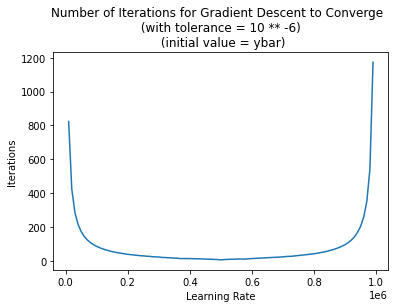

The fastest learning rate is 500000. It converges, with tolerance of 1e-06, in 6 steps.


In [6]:
# do a grid search to find the fastest descent
tolerance = 10 ** -6
learning_rates = range(10000, 10 ** 6, 10000)
steps = []

for learning_rate in learning_rates:
    n_steps = gd(y, learning_rate, tolerance)["steps"]
    steps.append(n_steps)

# plot the results
plt.title("Number of Iterations for Gradient Descent to Converge  \n (with tolerance = 10 ** -6) \n (initial value = ybar)")
plt.ylabel("Iterations")
plt.xlabel("Learning Rate")
plt.plot(learning_rates, steps)
plt.show()

# find the best rate
min_steps = min(steps)
min_idx = steps.index(min_steps)
arg_min_learning_rate = learning_rates[min_idx]
out_str = "The fastest learning rate is %s. It converges, with tolerance of %s, in %s steps." %(arg_min_learning_rate, tolerance, min_steps)
print(out_str)

In [7]:
# estimation using Gradient Descent with best learning rate of 500000.

gd_estimates = gd(y, 500000, 10 ** -6)["estimates"]
gd_estimates

[8805.69387755102,
 10263.56923039718,
 9924.309170133882,
 9892.38906091601,
 9892.17651656667,
 9892.176819757902,
 9892.17681930912]

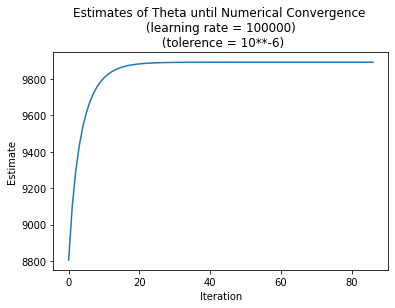

In [8]:
# estimation using Gradient Descent with learning rate of 100000.

gd_estimates_100k = gd(y, 100000, 10 ** -6)["estimates"]

gd_estimates_100k

plt.plot(gd_estimates_100k)
plt.xlabel("Iteration")
plt.ylabel("Estimate")
plt.title("Estimates of Theta until Numerical Convergence \n (learning rate = 100000) \n (tolerence = 10**-6)")
plt.show()

### Newton-Raphson: Math

Using Newton-Raphson, we get the interative eqaution $\theta^{(m)} = \theta^{(m-1)} -\frac{U^{(m-1)}}{U'^{(m-1)}}$.

Computationally, when, for some $m$, $\theta^{(m)}$ and $\theta^{(m-1)}$ are within a defined tolerance, the algorithm has converged.

I will demonstrate that Newton-Raphson converges with very few iterations.

### Newton-Raphson: Code

In [9]:
# estimation using Newton-Raphson

# initialize the estimate
theta = y.mean()

newton_estimates = []
newton_estimates.append(theta)
newton_lrs = []

for i in range(0, 6):
    U = score(y, theta, 2)
    dU_dtheta = derivative_of_score(y, theta, 2)
    theta = theta -  U / dU_dtheta
    newton_estimates.append(theta)
    newton_lrs.append(-1/dU_dtheta)
    
newton_estimates

[8805.69387755102,
 9633.77740849518,
 9875.898292055434,
 9892.110003552083,
 9892.17681818154,
 9892.176819309781,
 9892.176819309783]

In [10]:
abs(newton_estimates[6] - newton_estimates[5])< 10**-6

True

Newton-Raphson converges, with a tolerence of 10**-6, on the 6th iteration.

### Method of Scoring: Math

Using approximating $U'$ with $-E(U) = J$ in the Newton-Raphson iterative equation, we get the Method of Scoring's iterative equation:
$$\theta^{(m)} = \theta^{(m-1)} +\frac{U^{(m-1)}}{J^{(m-1)}}$$

Computationally, when, for some $m$, $\theta^{(m)}$ and $\theta^{(m-1)}$ are within a defined tolerance, the algorithm has converged.

The Method of Scoring converges with very few iterations.

### Method of Scoring: Code

In [11]:
# Estimation using the Method of Scoring

# initialize the estimate
theta = y.mean()

scoring_estimates = []
scoring_estimates.append(theta)
scoring_lrs = []

for i in range(0, 6):
    U = score(y, theta, 2)
    VU = information(y, theta, 2)
    theta = theta + U / VU
    scoring_estimates.append(theta)
    scoring_lrs.append(1/VU)
    
scoring_estimates

[8805.69387755102,
 9959.20419949967,
 9892.402372958704,
 9892.176821881172,
 9892.176819309781,
 9892.176819309783,
 9892.176819309781]

In [12]:
abs(scoring_estimates[5] - scoring_estimates[4])< 10**-6

True

The Method of Scoring converges, with a tolerence of 10**-6, on the 5th iteration.

## Comparison

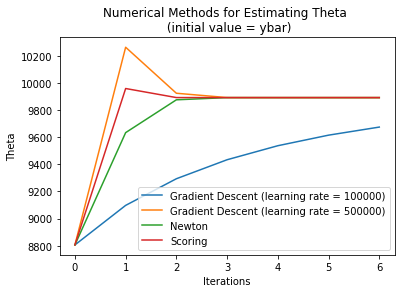

In [13]:
# plot the estimates against each other
plt.title("Numerical Methods for Estimating Theta \n (initial value = ybar)")
plt.plot(gd_estimates_100k[0:len(gd_estimates)], label = "Gradient Descent (learning rate = 100000)")
plt.plot(gd_estimates, label = "Gradient Descent (learning rate = 500000)")
plt.plot(newton_estimates, label = "Newton")
plt.plot(scoring_estimates, label = "Scoring")
plt.ylabel("Theta")
plt.xlabel("Iterations")
plt.legend()
plt.show()

It can be seen that all three algorithms converge to roughly the same parameter estimate for theta. However, gradient descent converges slowly if the wrong learning rate is chosen.

One might wonder why choosing the learning rate of 500000 produces quick congervence. The answer is that Newton-Raphson and the Method of Scoring can be interpreted as extentions of Gradeint Descent with a non constant learning rate.

For Newton-Raphson,  we can rewrite the interative equation as $\theta^{(m)} = \theta^{(m-1)} + \gamma_{Newton} U^{(m-1)}$, where $\gamma_{Newton} =\frac{-1}{U'^{(m-1)}}$.

For the Method of Scoring, we can rewrite the interative equation as $\theta^{(m)} = \theta^{(m-1)} + \gamma_{Scoring} U^{(m-1)}$, where $\gamma_{Scoring} =\frac{1}{J^{(m-1)}}$.

Earlier, when implementing Newton-Raphson and the Method of Scoring, I collected the "learing rates" as defined here. We can see that the very close to 500000 as the estimates of $\theta$ converge.

In [14]:
# display the Newton-Raphson "Learing Rates"
newton_lrs

[284003.5430078167,
 437816.5870506586,
 495168.62976214424,
 499244.170966234,
 499261.0314728877,
 499261.0317576009]

In [15]:
# display the Method of Scoring "Learing Rates"
newton_lrs

[284003.5430078167,
 437816.5870506586,
 495168.62976214424,
 499244.170966234,
 499261.0314728877,
 499261.0317576009]

In addition, the convergence of learning rates was not merely an accident due to the path of convergence. For any values near the final estimate of $\theta \approx 9892$, the values of all three learning rate are similar.

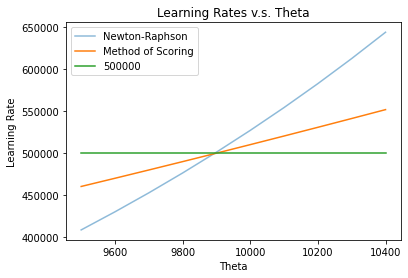

In [16]:
# generate a plot of the learning rates at many values of theta

theta_values = list(range(9500, 10500, 100))
newton_lr = [-1/derivative_of_score(y, theta, 2) for theta in theta_values]
scoring_lr = [1/information(y, theta, 2) for theta in theta_values]
lr = [500000 for theta in theta_values]

plt.title("Learning Rates v.s. Theta")
plt.xlabel("Theta")
plt.ylabel("Learning Rate")
plt.plot(theta_values, newton_lr, label = "Newton-Raphson", alpha = .5)
plt.plot(theta_values, scoring_lr, label = "Method of Scoring", alpha = 1)
plt.plot(theta_values, lr, label = "500000")
plt.legend()
plt.show()

## Closed Form Solution

I conclude with a derivation of a closed formed solution for $\hat\theta_{MLE}$. Since, I have decided to fit a Wiebull distribution with known $\lambda$, a closed form solution is possible.

Since $U$ is the score function, which is the deivative of the likelihood w.r.t $\theta$, we can solve $U = 0$ for $\theta$ to find $\hat{\theta}_{MLE}$:

$$U = \sum\limits_{i=1}^N \Big[ \frac{-\lambda}{\theta} + \frac{\lambda y_i^\lambda}{\theta^{\lambda +1}} \Big] = 0$$

$$\Rightarrow ... \Rightarrow$$ 

$$\hat{\theta}_{MLE}=\Bigg(\frac{\sum\limits_{i=1}^N y_i^\lambda}{N} \Bigg)^{\frac{1}{\lambda}}$$

Note: This solution assumes that $\lambda$ is known. Otherwise I could have to differentiate the liklihood w.r.t. $\lambda$ as well to find $\hat{\lambda}_{MLE}$. The FOC for $\lambda$ cannot be solved symbolically.

Finally, I compute $\hat{\theta}_{MLE}$ using the closed form equation which I derived.

In [17]:
def theta_closed_form(y, l):
    return ((y ** l).sum() / len(y)) ** (1/l)

In [18]:
theta_closed_form(y, 2)

9892.176819309781